In [1]:

import gym
import numpy as np
import random

# Define a custom environment for drone navigation
class DroneEnv(gym.Env):
    def __init__(self):
        super(DroneEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(8)  # 8 possible actions
        self.observation_space = gym.spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)
        self.state = np.array([5, 5])  # Start position
        self.target = np.array([8, 8])  # Target position
        self.obstacles = [np.array([6, 6]), np.array([7, 7])]  # Obstacles
        self.epsilon = 0.1  # Exploration rate

    def reset(self):
        self.state = np.array([5, 5])
        return self.state

    def step(self, action):
        if random.random() < self.epsilon:  # Exploration
            action = self.action_space.sample()

        # Define 8-direction movement
        movements = [(0, 1), (0, -1), (-1, 0), (1, 0), (1, 1), (-1, 1), (1, -1), (-1, -1)]
        move = movements[action]
        self.state = np.clip(self.state + move, 0, 10)  # Ensure within bounds

        # Check for collisions and termination conditions
        reward = -1
        done = False
        if any(np.array_equal(self.state, obs) for obs in self.obstacles):
            reward = -10  # Penalty for hitting an obstacle
            done = True
        elif np.array_equal(self.state, self.target):
            reward = 10  # Reward for reaching the target
            done = True

        return self.state, reward, done, {}

    def render(self):
        print(f"Drone Position: {self.state}, Target: {self.target}, Obstacles: {self.obstacles}")

In [2]:
import heapq

# Heuristic function for A* (Euclidean distance)
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

# A* pathfinding function
def a_star(start, goal, obstacles, grid_width, grid_height):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == goal:
            # Reconstruct path from goal to start
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]

        for direction in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            if neighbor in obstacles or not (0 <= neighbor[0] < grid_width and 0 <= neighbor[1] < grid_height):
                continue

            tentative_g_score = g_score[current] + 1
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                if neighbor not in [i[1] for i in open_set]:
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []  # No path found if the open_set is exhausted

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for navigation graph
def visualize_graph():
    G = nx.DiGraph()
    G.add_nodes_from([1, 2, 3, 4, 5])
    G.add_edge(1, 2, weight=1.5)
    G.add_edge(1, 3, weight=2.0)
    G.add_edge(2, 4, weight=1.2)
    G.add_edge(3, 4, weight=0.9)
    G.add_edge(4, 5, weight=1.8)
    G.add_edge(3, 5, weight=1.5)

    # Define layout
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", edge_color="gray", arrows=True)

    # Annotate with edge weights
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title("Drone Navigation Graph")
    plt.show()


In [4]:
from stable_baselines3 import PPO

# Initialize environment and PPO model
env = DroneEnv()
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\akqp4\AppData\Local\Programs\Python\Python313\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 67       |
|    ep_rew_mean     | -72.6    |
| time/              |          |
|    fps             | 3079     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 70.1       |
|    ep_rew_mean          | -74.9      |
| time/                   |            |
|    fps                  | 1901       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01210198 |
|    clip_fraction        | 0.147      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.07      |
|    explained_variance   | -0.000889  |
|    learning_rate        | 0.0003     |
|   

In [5]:
obstacles = [(6, 6), (7, 7)]
start, goal = (5, 5), (8, 8)
path = a_star(start, goal, obstacles, grid_width=10, grid_height=10)
print("Optimal path found by A*:", path)

# Test the trained agent
obs = env.reset()
for _ in range(20):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
        break


Optimal path found by A*: [(5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (8, 8)]
Drone Position: [4 5], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [3 6], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [4 5], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [4 4], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [4 3], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [4 2], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [4 3], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [3 3], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [4 2], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [4 1], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [5 2], Target: [8 8], Obstacles: [array([6, 6]), array([7, 7])]
Drone Position: [4 2], Target: [8 8], Obstacl

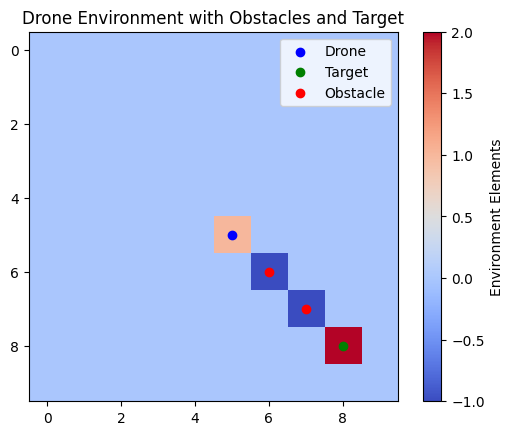

In [6]:
import matplotlib.pyplot as plt

def visualize_environment(drone_pos, target_pos, obstacles):
    # Define the grid size
    grid_size = (10, 10)

    # Create a blank grid
    env_grid = np.zeros(grid_size)

    # Mark obstacles
    for obs in obstacles:
        env_grid[obs[0], obs[1]] = -1  # Obstacles marked as -1

    # Mark target position
    env_grid[target_pos[0], target_pos[1]] = 2  # Target marked as 2

    # Mark drone position
    env_grid[drone_pos[0], drone_pos[1]] = 1  # Drone marked as 1

    # Plot the grid
    plt.imshow(env_grid, cmap="coolwarm", origin="upper")
    plt.colorbar(label="Environment Elements")
    plt.scatter(drone_pos[1], drone_pos[0], color='blue', label="Drone")
    plt.scatter(target_pos[1], target_pos[0], color='green', label="Target")
    for obs in obstacles:
        plt.scatter(obs[1], obs[0], color='red', label="Obstacle" if obs == obstacles[0] else "")

    plt.legend(loc="upper right")
    plt.title("Drone Environment with Obstacles and Target")
    plt.show()

# Test Visualization
drone_pos = (5, 5)
target_pos = (8, 8)
obstacles = [(6, 6), (7, 7)]
visualize_environment(drone_pos, target_pos, obstacles)


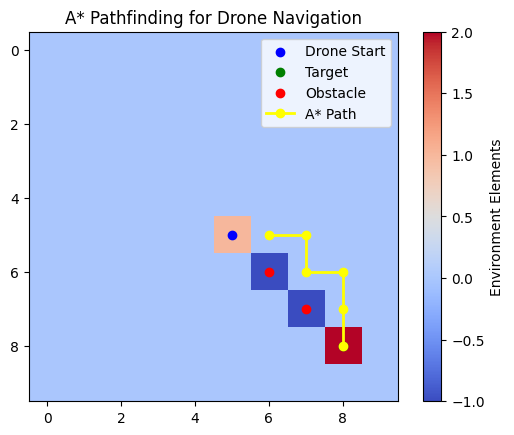

In [7]:
def visualize_astar_path(drone_pos, target_pos, obstacles, path):
    # Create a grid for the environment
    grid_size = (10, 10)
    env_grid = np.zeros(grid_size)

    # Mark obstacles
    for obs in obstacles:
        env_grid[obs[0], obs[1]] = -1  # Obstacles marked as -1

    # Mark target position
    env_grid[target_pos[0], target_pos[1]] = 2  # Target marked as 2

    # Mark drone position
    env_grid[drone_pos[0], drone_pos[1]] = 1  # Drone marked as 1

    # Plot the grid with A* path
    plt.imshow(env_grid, cmap="coolwarm", origin="upper")
    plt.colorbar(label="Environment Elements")
    plt.scatter(drone_pos[1], drone_pos[0], color='blue', label="Drone Start")
    plt.scatter(target_pos[1], target_pos[0], color='green', label="Target")
    for obs in obstacles:
        plt.scatter(obs[1], obs[0], color='red', label="Obstacle" if obs == obstacles[0] else "")

    # Draw the A* path
    if path:
        path_x, path_y = zip(*path)
        plt.plot(path_y, path_x, color="yellow", linewidth=2, marker="o", label="A* Path")

    plt.legend(loc="upper right")
    plt.title("A* Pathfinding for Drone Navigation")
    plt.show()

# Test A* Visualization
path = a_star(start=drone_pos, goal=target_pos, obstacles=obstacles, grid_width=10, grid_height=10)
visualize_astar_path(drone_pos, target_pos, obstacles, path)

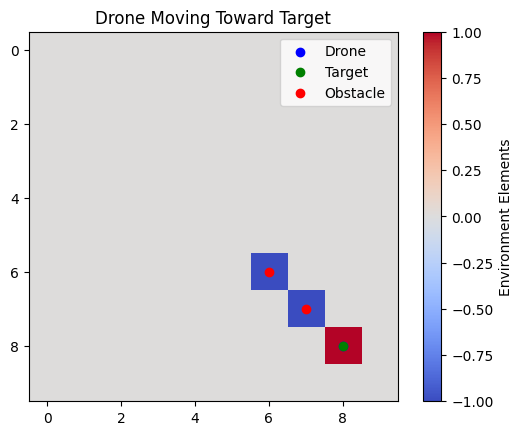

In [14]:
import time
from IPython.display import clear_output

def visualize_dynamic_path(drone_pos, target_pos, obstacles, path):
    for step in path:
        clear_output(wait=True)

        # Create environment grid
        grid_size = (10, 10)
        env_grid = np.zeros(grid_size)

        # Mark obstacles
        for obs in obstacles:
            env_grid[obs[0], obs[1]] = -1  # Obstacles marked as -1

        # Mark target
        env_grid[target_pos[0], target_pos[1]] = 2  # Target marked as 2

        # Mark drone position
        env_grid[step[0], step[1]] = 1  # Drone marked as 1

        # Plot grid
        plt.imshow(env_grid, cmap="coolwarm", origin="upper")
        plt.colorbar(label="Environment Elements")
        plt.scatter(step[1], step[0], color='blue', label="Drone")
        plt.scatter(target_pos[1], target_pos[0], color='green', label="Target")
        for obs in obstacles:
            plt.scatter(obs[1], obs[0], color='red', label="Obstacle" if obs == obstacles[0] else "")

        plt.legend(loc="upper right")
        plt.title("Drone Moving Toward Target")
        plt.show()

        time.sleep(0.5)  # Adjust time as needed

# Execute dynamic visualization
drone_pos = (5, 5)
target_pos = (8, 8)
obstacles = [(6, 6), (7, 7)]
path = a_star(start=drone_pos, goal=target_pos, obstacles=obstacles, grid_width=10, grid_height=10)
visualize_dynamic_path(drone_pos, target_pos, obstacles, path)

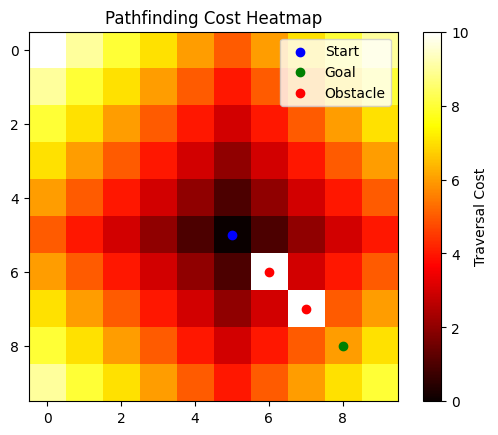

In [9]:
def visualize_cost_heatmap(start, goal, obstacles, grid_width, grid_height):
    # Initialize cost grid with high values
    cost_grid = np.full((grid_width, grid_height), np.inf)

    # Use A* to calculate cost to each cell from start
    open_set = [(0, start)]
    g_score = {start: 0}

    while open_set:
        _, current = heapq.heappop(open_set)
        cost_grid[current[0], current[1]] = g_score[current]

        # Explore neighbors
        for direction in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            if neighbor in obstacles or not (0 <= neighbor[0] < grid_width and 0 <= neighbor[1] < grid_height):
                continue

            tentative_g_score = g_score[current] + 1
            if tentative_g_score < g_score.get(neighbor, np.inf):
                g_score[neighbor] = tentative_g_score
                heapq.heappush(open_set, (tentative_g_score, neighbor))

    # Plot cost heatmap
    plt.imshow(cost_grid, cmap="hot", origin="upper")
    plt.colorbar(label="Traversal Cost")
    plt.scatter(start[1], start[0], color='blue', label="Start")
    plt.scatter(goal[1], goal[0], color='green', label="Goal")
    for obs in obstacles:
        plt.scatter(obs[1], obs[0], color='red', label="Obstacle" if obs == obstacles[0] else "")

    plt.legend(loc="upper right")
    plt.title("Pathfinding Cost Heatmap")
    plt.show()

# Visualize cost heatmap
start = (5, 5)
goal = (8, 8)
obstacles = [(6, 6), (7, 7)]
visualize_cost_heatmap(start, goal, obstacles, grid_width=10, grid_height=10)

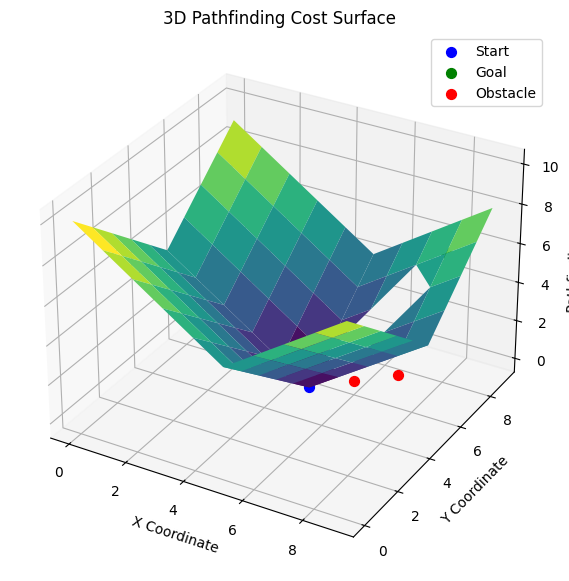

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_cost_surface(start, goal, obstacles, grid_width, grid_height):
    # Generate cost grid with A* similar to previous heatmap code
    cost_grid = np.full((grid_width, grid_height), np.inf)
    open_set = [(0, start)]
    g_score = {start: 0}

    while open_set:
        _, current = heapq.heappop(open_set)
        cost_grid[current[0], current[1]] = g_score[current]

        for direction in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            if neighbor in obstacles or not (0 <= neighbor[0] < grid_width and 0 <= neighbor[1] < grid_height):
                continue
            tentative_g_score = g_score[current] + 1
            if tentative_g_score < g_score.get(neighbor, np.inf):
                g_score[neighbor] = tentative_g_score
                heapq.heappush(open_set, (tentative_g_score, neighbor))

    # Create 3D surface plot
    x, y = np.meshgrid(range(grid_width), range(grid_height))
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, cost_grid.T, cmap="viridis", edgecolor="none")

    # Add start, goal, and obstacles
    ax.scatter(start[1], start[0], g_score[start], color='blue', s=50, label="Start")
    ax.scatter(goal[1], goal[0], g_score.get(goal, np.inf), color='green', s=50, label="Goal")
    for obs in obstacles:
        ax.scatter(obs[1], obs[0], 0, color='red', s=50, label="Obstacle" if obs == obstacles[0] else "")

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Pathfinding Cost')
    ax.set_title("3D Pathfinding Cost Surface")
    plt.legend()
    plt.show()

# Test 3D cost surface visualization
start = (5, 5)
goal = (8, 8)
obstacles = [(6, 6), (7, 7)]
visualize_cost_surface(start, goal, obstacles, grid_width=10, grid_height=10)

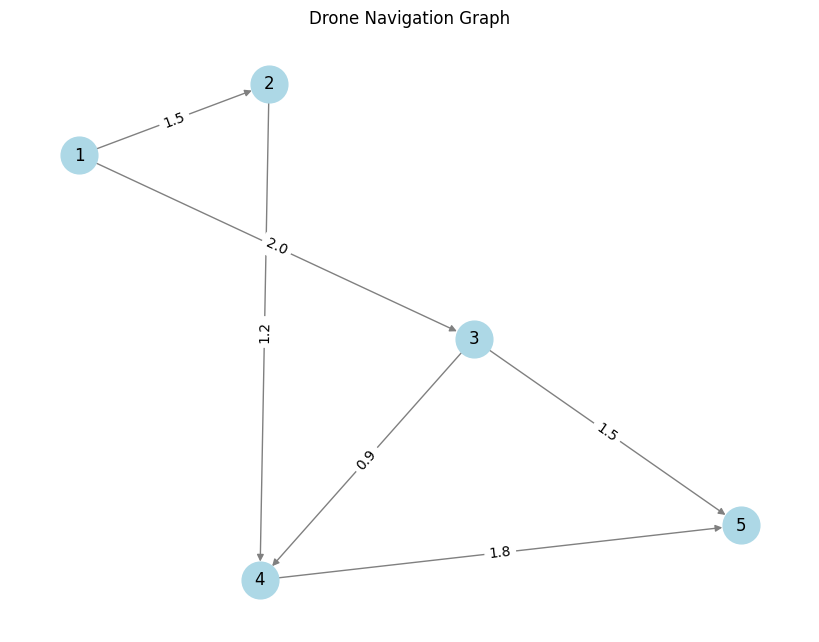

In [11]:
import networkx as nx

def visualize_navigation_graph():
    G = nx.DiGraph()
    G.add_nodes_from([1, 2, 3, 4, 5])
    G.add_edge(1, 2, weight=1.5)
    G.add_edge(1, 3, weight=2.0)
    G.add_edge(2, 4, weight=1.2)
    G.add_edge(3, 4, weight=0.9)
    G.add_edge(4, 5, weight=1.8)
    G.add_edge(3, 5, weight=1.5)

    # Define layout
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", edge_color="gray", arrows=True)

    # Annotate with edge weights
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title("Drone Navigation Graph")
    plt.show()

# Test the graph visualization
visualize_navigation_graph()